## Imports

In [1]:
library(tidyverse)
library(broom)
library(GGally)
library(glmnet)
library(caret)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.1 
v readr   2.1.2      v forcats 0.5.2 

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  me

## Read the Data

In [2]:
data <- read_csv("data/Employee.csv")
head(data)

Rows: 4653 Columns: 9
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


In [3]:
nrow(data)

[1] 4653

# Methods and Plan

Reminder: The problem we are focusing on is predicting whether an employee will leave the company.

Proposed method: Split the data into a variable selection data, a model training data and a model test data. Then, we can use the variable selection data to fit a Lasso model and select variables that does not have their coefficients reduced to zero by the model. Next, we can use the model training data to train a least squares regression model with variables selected by the Lasso model to get our prediction model. Finally, we can use the model test data to test how well our final least squares regression model does on predicting new observations.

### Why are we using this method?

As can be seen from the EDA visualization below and from the previous assignment, variables such as "Age" and "Experience in Current Domain" by themselves might not be good explanatory variables for the prediction target variable "LeaveOrNot". However, when combined with other variables it might not be the case. As such, to rule out which variables are not good explanatory variables, we can do variable selection with Lasso method. However, by doing so, we would need to split the training data into two: one for variable selection and one for model training to avoid "double dipping".

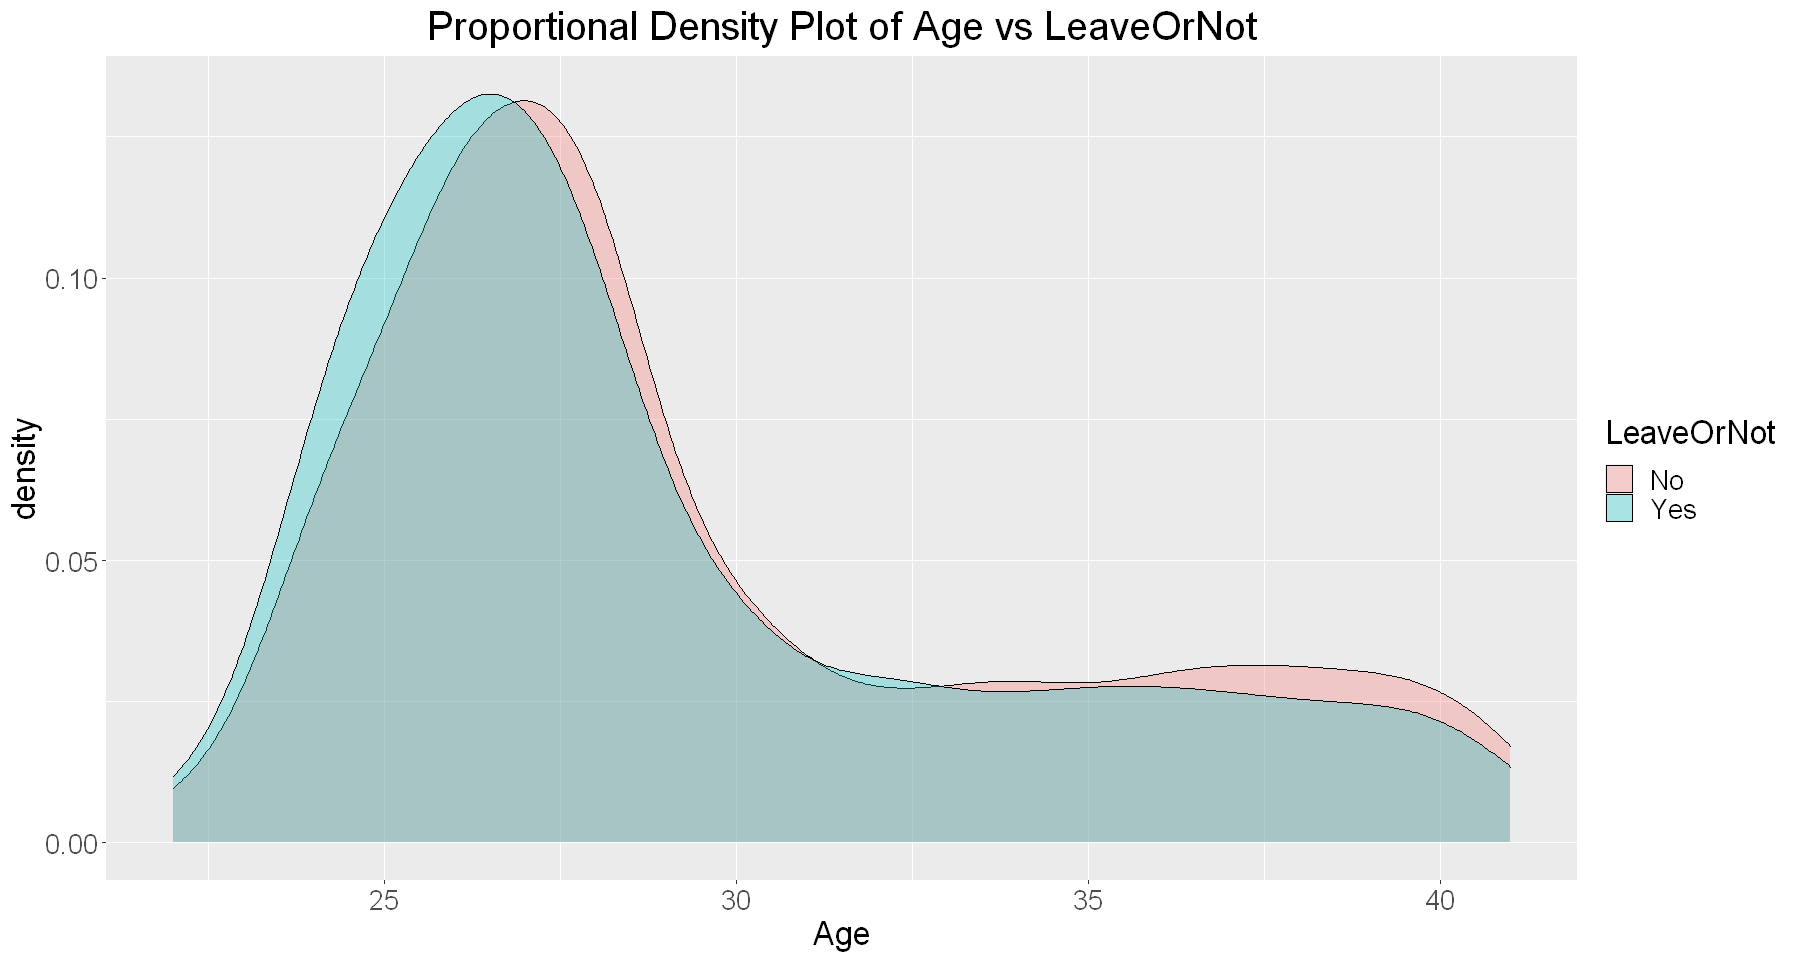

In [4]:
options(repr.plot.width=15, repr.plot.height=8)

data$LeaveOrNot[data$LeaveOrNot == 1] <- 'Yes'
data$LeaveOrNot[data$LeaveOrNot == 0] <- 'No'

data |>
    ggplot(aes(x = Age, fill = LeaveOrNot)) +
    geom_density(alpha = 0.3) +
    ggtitle("Proportional Density Plot of Age vs LeaveOrNot") + 
    xlab("Age") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

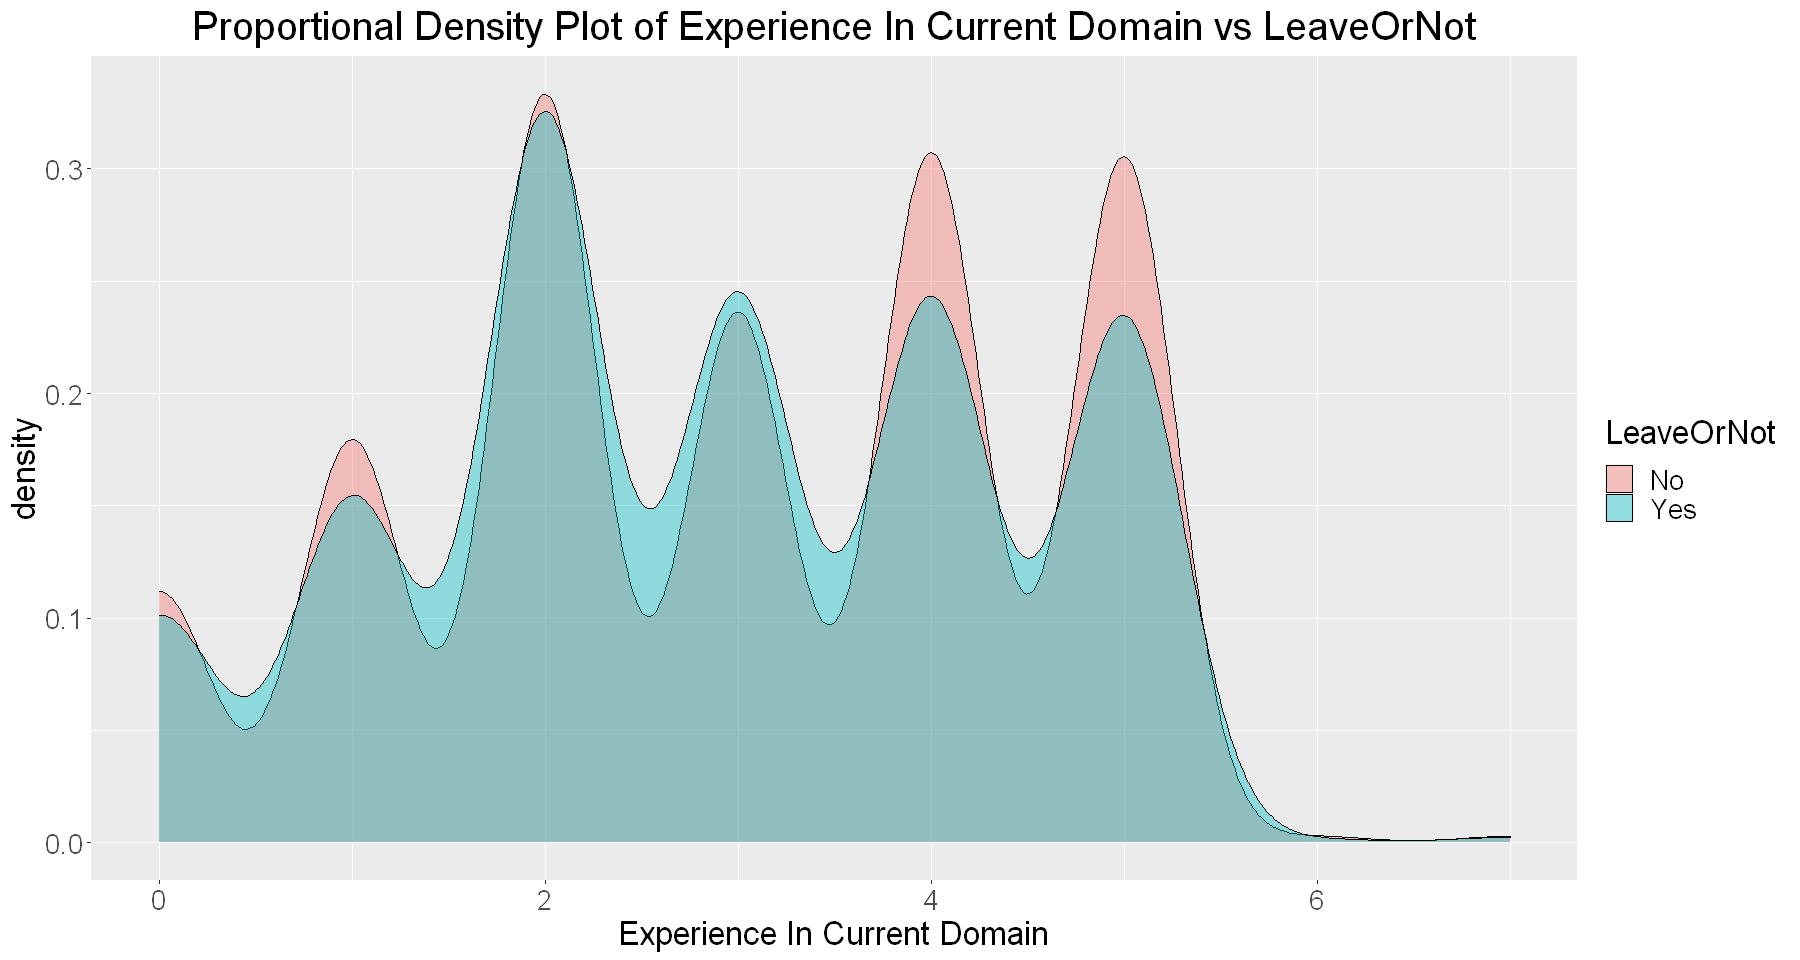

In [5]:
data |>
    ggplot(aes(x = ExperienceInCurrentDomain, fill = LeaveOrNot)) +
    geom_density(alpha = 0.4) +
    ggtitle("Proportional Density Plot of Experience In Current Domain vs LeaveOrNot") + 
    xlab("Experience In Current Domain") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

### Assumptions for Method to Work

The assumptions for both the Lasso model and the least squares regression model are similar which is denoted by the LINE acronym discussed in lecture:
- Linear relation between explanatory variables and response variable. In this case, linear relation between "LeaveOrNot" and all other variables.
- Errors are independent
- Normality of conditional distribution of errors
- Homoscedasticity

An additional assumption which helps improve the model is for there to be little to no multicollinearity between explanatory variables. 

### Potential Limitations to This Method

- We require splitting the data into three separate datasets for variable selection, model training, and model testing. Our data only has 4653 rows as seen above. This might cause an issue where we don't have enough sample data to do all three properly.
- Lasso variable selection does not account for interactions between variables. As such, we are limiting our model to only include addition between variables.
- This problem is a Survival Analysis problem which means treating it as a regular binomial classification problem may result in a poor model

## Implementation of a Proposed Model

In [6]:
data <- read_csv("data/Employee.csv")
data <- rowid_to_column(data, "ID")
head(data)

Rows: 4653 Columns: 9
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Bachelors,2017,Bangalore,3,34,Male,No,0,0
2,Bachelors,2013,Pune,1,28,Female,No,3,1
3,Bachelors,2014,New Delhi,3,38,Female,No,2,0
4,Masters,2016,Bangalore,3,27,Male,No,5,1
5,Masters,2017,Pune,3,24,Male,Yes,2,1
6,Bachelors,2016,Bangalore,3,22,Male,No,0,0


In [7]:
set.seed(1)
data_train <- 
    data |> 
    slice_sample(prop = 0.9)

data_test <- 
    data |>
    anti_join(data_train, by = "ID")

data_variable_selection <- 
    data_train |> 
    slice_sample(prop = 0.2)

data_train <-
    data_train |>
    anti_join(data_variable_selection, by = "ID")

nrow(data_variable_selection)
nrow(data_train)
nrow(data_test)

[1] 837

[1] 3350

[1] 466

In [8]:
X_variable_selection <- model.matrix(object = LeaveOrNot ~ .-ID,
  data = data_variable_selection)[, -1]

Y_variable_selection <- data.frame(data_variable_selection)[, "LeaveOrNot"]

lasso_model = cv.glmnet(x = X_variable_selection,
                     y = Y_variable_selection,
                     alpha = 1)
lasso_model


Call:  cv.glmnet(x = X_variable_selection, y = Y_variable_selection,      alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure       SE Nonzero
min 0.003255    38  0.1954 0.006306       9
1se 0.030355    14  0.2012 0.007413       7

In [9]:
selected_variables <- as.tibble(as.matrix(coef(lasso_model, s = "lambda.1se")),
                                rownames='covariate')
selected_variables

Warning message:
"`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


covariate,s1
<chr>,<dbl>
(Intercept),-27.886694765
EducationMasters,0.087518707
EducationPHD,0.000000000
JoiningYear,0.014141388
CityNew Delhi,-0.004653911
CityPune,0.120112663
PaymentTier,-0.064898933
Age,-0.002896013
GenderMale,-0.106052984


We see EverBenchedYes and ExperienceInCurrentDomain is zeroed by the model and EducationPHD is also zeroes. However, EducationMasters still matters so we only select out EverBenched and ExperienceInCurrentDomain

In [10]:
data_train <- data_train |>
            select(-ID, -EverBenched, -ExperienceInCurrentDomain)
data_test <- data_test |>
            select(-ID, -EverBenched, -ExperienceInCurrentDomain)
head(data_train)

Education,JoiningYear,City,PaymentTier,Age,Gender,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Bachelors,2014,Bangalore,3,25,Female,0
Masters,2016,New Delhi,3,28,Female,0
Bachelors,2014,Bangalore,3,24,Male,0
Bachelors,2013,Bangalore,1,28,Female,0
Bachelors,2018,Bangalore,3,26,Female,1
Bachelors,2014,Pune,3,27,Male,0


In [11]:
final_model <- glm(LeaveOrNot ~ ., family = "binomial", data = data_train)
tidy(final_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-436.10661960,44.367945840,-9.8293173,8.418750e-23
EducationMasters,0.78873214,0.111912915,7.0477312,1.818585e-12
EducationPHD,-0.10290455,0.221679691,-0.4642038,6.425017e-01
JoiningYear,0.21695197,0.022019166,9.8528696,6.661436e-23
CityNew Delhi,-0.50513882,0.113910341,-4.4345299,9.227340e-06
CityPune,0.74737718,0.095812966,7.8003763,6.172285e-15
PaymentTier,-0.30252088,0.070808398,-4.2723871,1.933915e-05
Age,-0.02120285,0.008276686,-2.5617565,1.041443e-02
GenderMale,-0.93683960,0.082428405,-11.3654947,6.211161e-30


In [12]:
prediction = round(predict(final_model, newdata = data_test |> select(-LeaveOrNot), type = "response"), 0)
prediction

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  1   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
  0   1   0   0   0   0   1   0   0   1   0   1   0   1   1   1   0   0   0   0 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  0   1   0   0   0   0   1   0   0   1   1   0   0   0   0   1   1   0   1   0 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
  0   0   0   1   0   0   0   1   0   1   0   0   0   0   0   0   1   0   0   0 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
  1   0   0   0   0   0   1   1   0   0   0   1   0   0   0   0   0   0   0   0 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
  0   0   1   0   0   0   1   0   0   0   0   0   1   0   0   1   1   0   1   0 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
  0   0   0   1   1   0   0   1   0   0   1   0   0   1   0   0   0   0   0   0 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
  1   0   0   1   0   0   1   1   1   0   0   1   1   0   0   0   0   0   1   0 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   1   0   0 
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 
  0   0   0   0   0   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0 
221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 
  0   0   0   0   1   0   0   0   1   1   0   1   1   1   0   0   0   1   1   0 
241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 
  0   0   0   0   1   0   0   0   1   0   1   0   0   0   1   0   0   1   0   0 
261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 
  0   0   0   0   0   1   0   0   0   1   1   0   0   0   0   0   0   0   0   0 
281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 
  0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0   0 
301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 
  0   0   0   0   0   0   0   0   0   1   1   0   0   0   0   0   0   1   0   0 
321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 
  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   1   1   0   0   0 
341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 
  1   0   1   0   0   0   0   0   0   0   1   0   0   0   0   1   1   0   0   0 
361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   0 
381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 
  0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0 
401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 
  0   0   0   0   0   0   0   0   1   0   0   1   0   0   0   1   0   0   0   0 
421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 
  1   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1 
441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 
  0   0   1   1   1   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0 
461 462 463 464 465 466 
  0   0   0   0   1   1

In [13]:
conf_matrix <- 
    confusionMatrix(
    data = as.factor(prediction),
    reference = data_test |> select(LeaveOrNot) |> unlist() |> as.factor(),
    positive = "1"
)
conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 284  84
         1  33  65
                                         
               Accuracy : 0.7489         
                 95% CI : (0.707, 0.7877)
    No Information Rate : 0.6803         
    P-Value [Acc > NIR] : 0.0007121      
                                         
                  Kappa : 0.3653         
                                         
 Mcnemar's Test P-Value : 3.791e-06      
                                         
            Sensitivity : 0.4362         
            Specificity : 0.8959         
         Pos Pred Value : 0.6633         
         Neg Pred Value : 0.7717         
             Prevalence : 0.3197         
         Detection Rate : 0.1395         
   Detection Prevalence : 0.2103         
      Balanced Accuracy : 0.6661         
                                         
       'Positive' Class : 1              
                                         

The result is not great but a little expected with an accuracy of 0.75 which is decent compared to the base model (predicting only 0 which is not leave everytime) which would results in an accuracy of 0.66. This might be due to the lack of data as I mentioned earlier as having to split the scarce data that we have into 3 is not very effective. Another issue with this is that this is a case of Survival Analysis and require more complex models such as the Kaplan-Meier Survival Curve or the Cox Proportional Hazards Model. A couple of ways we can address this is by increasing the sample data size (which is not practical and not necessarily effective), or by implementing Survival Analysis techniques and models (Which should be more effective and practical to do).